# 图像融合

In [1]:
import numpy as np
%matplotlib  inline
import cv2
import matplotlib.pyplot as plt
import pywt

In [2]:
src1 = cv2.cvtColor(cv2.imread('../datas/f2.jpg'),cv2.COLOR_BGR2RGB)
src2 = cv2.cvtColor(cv2.imread('../datas/f1.jpg'),cv2.COLOR_BGR2RGB)

## 1.基于PCA图像融合

In [3]:
def fusion_pca(src1,src2):
    assert src1.shape == src2.shape
    shape = src1.shape
    rows,cols = src1.shape[0],src1.shape[1]
    image_size = src1.size
    src1_new = np.reshape(src1,(1,image_size)).astype(np.float32)
    src2_new = np.reshape(src2,(1,image_size)).astype(np.float32)
    all_image = np.concatenate((src1_new,src2_new),axis=0)
    cov_image = np.cov(all_image)
    D,V = np.linalg.eig(cov_image)
    if D[0] > D[1]:
        a = V[:,0] / (V[:,0]+1e-5).sum()
    else:
        a = V[:,1] / (V[:,1]+1e-5).sum()
    dst = src1_new * a[0] + src2_new * a[1]
    dst = np.reshape(dst,shape)
    return dst

In [4]:
dst = fusion_pca(src1,src2)

In [5]:
dst = np.clip(dst,0,255)
dst = np.uint8(dst)

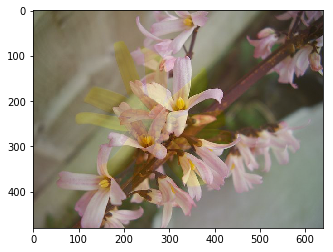

In [6]:
plt.imshow(dst)

## 2.基于小波图像融合

In [7]:
def fusion_dwb(src1,src2,zt=1,ap=2,mp=0):
    coeffss = []

    coeffss = []
    coeffss.append(pywt.wavedec2(src1,'db1',level=zt))
    
    # 低通
    if mp == 0:
        cAF = coeffss[0][0]
        for coeffs in coeffss[1:]:
            cAF += coeffs[0]
        cAF = cAF / len(coeffss)
    # 高通
    if ap == 2:
        hipassF = coeffss[0][1:]
        for coeffs in coeffss[1:]:   # every image
            for idxLevel, HVDs in enumerate(coeffs[1:]):   # every level
                for idxDirec, HVD in enumerate(HVDs):
                    maxMap = hipassF[idxLevel][idxDirec] < HVD
                    hipassF[idxLevel][idxDirec][maxMap] = HVD[maxMap]
    coeffsFusion = [cAF,] + hipassF
    dst = pywt.waverec2(coeffsFusion, 'db1')
    dst = np.clip(dst,0,255)
    dst = np.uint8(dst)
    return dst

In [8]:
dst = fusion_dwb(src1,src2)

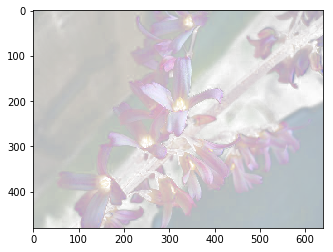

In [9]:
plt.imshow(dst)

## 基于导向滤波图像融合

参考：

[1]. https://github.com/sanuj/fuse-img

In [10]:
# SET PARAMETERS
r_1 = 45
eps_1 = 0.3
r_2 = 7
eps_2 = 0.000001

# Flag to use OpenCV's Guided Filter
use_opencv = True

In [11]:
# Our Implementation of Guided Filter ###################################################
# src: source image
# guide: guide image
# r: radius of window
# eps: epsilon
#
# returns refined filters
def guidedFilter(src, guide, r, eps):
    # Convert 1 byte uinsigned interger to 4 byte float
    src = np.array(src, np.float32)
    guide = np.array(guide, np.float32)

    # Different padding options available
    src_pad = np.pad(src, ((r,r),(r,r),(0,0)), 'reflect')
    # src_pad = np.pad(src, ((r,r),(r,r),(0,0)), 'constant', constant_values=0)
    guide = np.pad(guide, ((r,r),(r,r),(0,0)), 'reflect')
    # guide = np.pad(guide, ((r,r),(r,r),(0,0)), 'constant', constant_values=0)
    
    # Initialize a, b and output
    w = 2 * r + 1
    a_k = np.zeros(src_pad.shape[0:2], np.float32)
    b_k = np.zeros(src_pad.shape[0:2], np.float32)
    out = np.array(src, np.uint8, copy=True)
    
    # Calculate a and b by taking a window of size w * w
    for i in range(r, src_pad.shape[0]-r):
        for j in range(r, src_pad.shape[1]-r):
            # Initialize windows
            I = guide[i-r : i+r+1, j-r : j+r+1, 0]
            P = src_pad[i-r : i+r+1, j-r : j+r+1, 0]

            # Calculate each value in matrix a and b
            temp = np.dot(np.ndarray.flatten(I), np.ndarray.flatten(P))/(w*w)
            mu_k = np.mean(I)
            del_k = np.var(I)
            P_k_bar = np.mean(P)
            a_k[i,j] = (temp - mu_k * P_k_bar) / (del_k + eps)
            b_k[i,j] = P_k_bar - a_k[i,j] * mu_k


    # Mean of parameters in a and b due to multiple windows
    for i in range(r, src_pad.shape[0]-r):
        for j in range(r, src_pad.shape[1]-r):
            # Calculate mean
            a_k_bar = a_k[i-r : i+r+1, j-r : j+r+1].sum()/(w*w)
            b_k_bar = b_k[i-r : i+r+1, j-r : j+r+1].sum()/(w*w)
            
            # Calculate refined weights
            out[i-r,j-r] = np.round(a_k_bar * guide[i,j] + b_k_bar)

    return out

In [12]:
#### BASE LAYERS AND DETAIL LAYERS ############################################################
b1 = np.array(cv2.blur(src1, (31,31)), np.int16)
d1 = np.array(src1, np.int16) - b1

In [13]:
b2 = np.array(cv2.blur(src2, (31,31)), np.int16)
d2 = np.array(src2, np.int16) - b2


(([], <a list of 0 Text xticklabel objects>),
 ([], <a list of 0 Text yticklabel objects>))

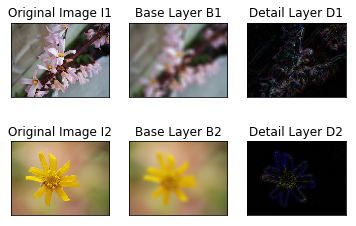

In [14]:
plt.figure("Two scale image decomposition")
plt.subplot(231), plt.imshow(src1), plt.title('Original Image I1')
plt.xticks([]), plt.yticks([])
plt.subplot(232), plt.imshow(np.array(b1, np.uint8)), plt.title('Base Layer B1')
plt.xticks([]), plt.yticks([])
plt.subplot(233), plt.imshow(np.array(abs(d1), np.uint8)), plt.title('Detail Layer D1')
plt.xticks([]), plt.yticks([])
plt.subplot(234), plt.imshow(src2), plt.title('Original Image I2')
plt.xticks([]), plt.yticks([])
plt.subplot(235), plt.imshow(np.array(b2, np.uint8)), plt.title('Base Layer B2')
plt.xticks([]), plt.yticks([])
plt.subplot(236), plt.imshow(np.array(abs(d2), np.uint8)), plt.title('Detail Layer D2')
plt.xticks([]), plt.yticks([])

In [15]:

#### SALIENCY MAPS ###########################################################################
laplacian1 = abs(cv2.Laplacian(src1, cv2.CV_64F))
s1 = cv2.GaussianBlur(laplacian1, (5,5), 0)
laplacian2 = abs(cv2.Laplacian(src2, cv2.CV_64F))
s2 = cv2.GaussianBlur(laplacian2, (5,5), 0)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(([], <a list of 0 Text xticklabel objects>),
 ([], <a list of 0 Text yticklabel objects>))

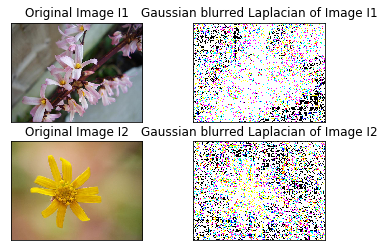

In [16]:
# Plot Saliency Maps
plt.figure("Saliency features")
plt.subplot(221), plt.imshow(src1), plt.title('Original Image I1')
plt.xticks([]), plt.yticks([])
plt.subplot(222), plt.imshow(laplacian1), plt.title('Gaussian blurred Laplacian of Image I1')
plt.xticks([]), plt.yticks([])
plt.subplot(223), plt.imshow(src2), plt.title('Original Image I2')
plt.xticks([]), plt.yticks([])
plt.subplot(224), plt.imshow(laplacian2), plt.title('Gaussian blurred Laplacian of Image I2')
plt.xticks([]), plt.yticks([])

In [17]:
#### WEIGHT MAPS ##############################################################################
p1 = np.zeros(src1.shape, np.uint8)
p2 = np.zeros(src2.shape, np.uint8)
p1[s1 >= s2] = 1
p2[s2 > s1] = 1

(([], <a list of 0 Text xticklabel objects>),
 ([], <a list of 0 Text yticklabel objects>))

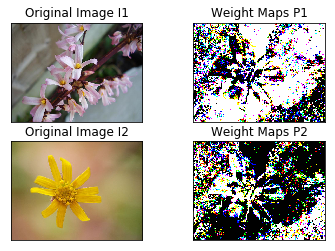

In [18]:
# Plot weight maps
plt.figure("Weight Maps")
plt.subplot(221), plt.imshow(src1), plt.title('Original Image I1')
plt.xticks([]), plt.yticks([])
plt.subplot(222), plt.imshow(p1*255), plt.title('Weight Maps P1')
plt.xticks([]), plt.yticks([])
plt.subplot(223), plt.imshow(src2), plt.title('Original Image I2')
plt.xticks([]), plt.yticks([])
plt.subplot(224), plt.imshow(p2*255), plt.title('Weight Maps P2')
plt.xticks([]), plt.yticks([])

In [19]:
#### REFINED WEIGHT MAPS ######################################################################
if(use_opencv):
    gf1 = cv2.ximgproc.createGuidedFilter(src1, r_1, eps_1)
    w1 = gf1.filter(p1)
else:
    w1 = guidedFilter(p1, src1, r_1, eps_1)

if(use_opencv):
    gf2 = cv2.ximgproc.createGuidedFilter(src2, r_2, eps_2)
    w2 = gf1.filter(p2)
else:
    w2 = guidedFilter(p2, src2, r_2, eps_2)

(([], <a list of 0 Text xticklabel objects>),
 ([], <a list of 0 Text yticklabel objects>))

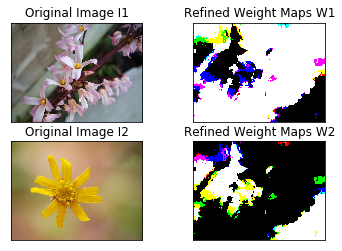

In [20]:
# Plot refined weights from Guided Filter
plt.figure("Refined Weight Maps")
plt.subplot(221), plt.imshow(src1), plt.title('Original Image I1')
plt.xticks([]), plt.yticks([])
plt.subplot(222), plt.imshow(w1*255), plt.title('Refined Weight Maps W1')
plt.xticks([]), plt.yticks([])
plt.subplot(223), plt.imshow(src2), plt.title('Original Image I2')
plt.xticks([]), plt.yticks([])
plt.subplot(224), plt.imshow(w2*255), plt.title('Refined Weight Maps W2')
plt.xticks([]), plt.yticks([])

In [21]:
#### FUSE IMAGES #################################################################

# Fuse base and detail images using refined maps from guided filter
bf = w1 * b1 + w2 * b2
df = w1 * d1 + w2 * d2

# Final fused image
fused_im = np.array(bf+df, np.uint8)

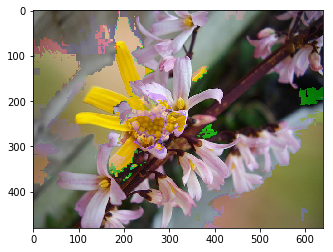

In [22]:
plt.imshow(fused_im)